## Sagnac Frequency - Backscatter Correction - Overview

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream
from scipy.signal import hilbert

from functions.get_fft import __get_fft
from functions.multitaper_psd import __multitaper_psd
from functions.welch_psd import __welch_psd
from functions.compute_cwt import __compute_cwt

from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
from functions.reduce import __reduce
from functions.multitaper_coherence import __multitaper_coherence
from functions.cross_correlation_windows import __cross_correlation_windows
from functions.cc_lag_matrix import __cc_lag_matrix
# from functions.load_backscatter_data import __load_backscatter_data

## Configurations

In [4]:
config = {}

config['ring'] = "U"

config['seed'] = "BW.DROMY..FJU"

config['path_to_sds'] = archive_path+"romy_archive/"

case = 10
# config['tbeg'] = UTCDateTime("2023-12-05 00:00")
# config['tend'] = UTCDateTime("2023-12-16 00:00")

config['tbeg'] = UTCDateTime("2023-12-08 00:00")
config['tend'] = UTCDateTime("2023-12-15 00:00")
flim1, flim2 = 302.425, 302.485

## note air ventilation on from 27-12-2023 !!!
# case = 11
# config['tbeg'] = UTCDateTime("2023-12-24 00:00")
# config['tend'] = UTCDateTime("2023-12-31 00:00")

# case = 12
# config['tbeg'] = UTCDateTime("2024-01-06 00:00")
# config['tend'] = UTCDateTime("2024-01-26 00:00")
# flim1, flim2 = 302.375, 302.475

# case = 13
# config['tbeg'] = UTCDateTime("2024-02-08 07:00")
# config['tend'] = UTCDateTime("2024-02-13 05:00")
# flim1, flim2 = 302.395, 302.45

# case = 14
# config['tbeg'] = UTCDateTime("2024-02-15 18:00")
# config['tend'] = UTCDateTime("2024-02-18 16:00")
# flim1, flim2 = 302.395, 302.45

# case = 16
# config['tbeg'] = UTCDateTime("2024-02-24 00:00")
# config['tend'] = UTCDateTime("2024-03-18 00:00")
# flim1, flim2 = 302.40, 302.47

case = 17
config['tbeg'] = UTCDateTime("2024-03-01 00:00")
config['tend'] = UTCDateTime("2024-03-20 00:00")
flim1, flim2 = 302.40, 302.47

## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

## Configurations

In [5]:
def __load_backscatter_data(tbeg, tend, ring, path_to_data):

    from os.path import isfile
    from obspy import UTCDateTime
    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range

    t1 = date.fromisoformat(str(UTCDateTime(tbeg).date))
    t2 = date.fromisoformat(str((UTCDateTime(tend)+86400).date))

    df = DataFrame()
    for dat in date_range(t1, t2):
        # print(dat)
        dat_str = str(dat)[:10].replace("-", "")
        file = f"FJ{ring}_{dat_str}_backscatter.pkl"

        if not isfile(path_to_data+file):
            _path = data_path+"sagnac_frequency/data/"

            out = DataFrame()
            for m in range(24):
                hour = str(m).rjust(2, '0')+":00:00"
                filename = f"FJU_{dat_str}_{hour}_backscatter.pkl"
                try:
                    _df = read_pickle(_path+filename)
                    out = concat([out, _df])
                except:
                    print(f" -> failed: {_path}{filename}")
                    continue

            if not out.empty:
                print(f" -> write to: {_path}backscatter/FJU_{dat_str}_backscatter.pkl")
                out.to_pickle(f"{_path}backscatter/FJU_{dat_str}_backscatter.pkl")
            else:
                continue

        try:
            df0 = read_pickle(path_to_data+file)
            df = concat([df, df0])
        except:
            print(f"error for {file}")

    ## trim to time interval
    df = df[df.time1 >= tbeg]
    df = df[df.time2 <= tend]

    df.reset_index(inplace=True)

    return df

In [6]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

# apply backscatter correction
# bs['fj_bs'] = bs.fj_fs * bs.term

# add seconds
bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

 -> failed: /import/kilauea-data/sagnac_frequency/data/FJU_20240321_00:00:00_backscatter.pkl
 -> failed: /import/kilauea-data/sagnac_frequency/data/FJU_20240321_01:00:00_backscatter.pkl
 -> failed: /import/kilauea-data/sagnac_frequency/data/FJU_20240321_02:00:00_backscatter.pkl
 -> failed: /import/kilauea-data/sagnac_frequency/data/FJU_20240321_03:00:00_backscatter.pkl
 -> failed: /import/kilauea-data/sagnac_frequency/data/FJU_20240321_04:00:00_backscatter.pkl
 -> failed: /import/kilauea-data/sagnac_frequency/data/FJU_20240321_05:00:00_backscatter.pkl
 -> failed: /import/kilauea-data/sagnac_frequency/data/FJU_20240321_06:00:00_backscatter.pkl
 -> failed: /import/kilauea-data/sagnac_frequency/data/FJU_20240321_07:00:00_backscatter.pkl
 -> failed: /import/kilauea-data/sagnac_frequency/data/FJU_20240321_08:00:00_backscatter.pkl
 -> failed: /import/kilauea-data/sagnac_frequency/data/FJU_20240321_09:00:00_backscatter.pkl
 -> failed: /import/kilauea-data/sagnac_frequency/data/FJU_20240321_10

In [7]:
def __backscatter_correction(m01, m02, phase0, w_obs, nominal_sagnac, cm_filter_factor=1.033):

    from numpy import array, sin, cos

    ## Correct for bias
    m1 = m01 * ( 1 + m01**2 / 4 )
    m2 = m02 * ( 1 + m02**2 / 4 )

    ## angular correction for phase
    phase = phase0 + 0.5 * m1 * m2 * sin( phase0 )

    ## compute squares of common-mode modulations
    m2c = ( m1**2 + m2**2 + 2*m1*m2*cos( phase ) ) / 4

    ## compute squares of differential-mode modulations
    m2d = ( m1**2 + m2**2 - 2*m1*m2*cos( phase ) ) / 4  ## different angle!

    ## correct m2c for gain saturation of a HeNe laser
    # m2c = m2c * ( 1 + ( beta + theta )**2 * fL**2 * I0**2 / ws**2 )
    m2c = m2c * cm_filter_factor

    ## compute backscatter correction factor
    M = m2c - m2d + 0.25 * m1**2 * m2**2 * sin(phase)**2

    ## correction term
    term = ( 4 + M ) / ( 4 - M )

    ## backscatter correction
    # BScorrection = -1 * ( term - 1 ) * nominal_sagnac
    # w_corrected = np.array(w_obs) + BScorrection

    w_corrected = array(w_obs) * term

    return w_corrected

In [8]:
# unwrap phases as one time series
bs['fj_ph'] = np.unwrap(bs.fj_ph)
bs['f1_ph'] = np.unwrap(bs.f1_ph)
bs['f2_ph'] = np.unwrap(bs.f2_ph)

# fractional beat modulations
m01 = bs.f1_ac / bs.f1_dc
m02 = bs.f2_ac / bs.f2_dc

# phase difference
ph1 = bs.f1_ph
ph2 = bs.f2_ph
phase0 = ph2 - ph1

# beat signal observed
w_obs = bs.fj_fs

# compute backscatter corrected signal
bs['fj_bs'] = __backscatter_correction(m01, m02, phase0, w_obs, 303.05, cm_filter_factor=1.033)

### Cut corrupt data periods

In [9]:
# times = [("2023-12-04T09:11", "2023-12-04T18:01")]

# for t1, t2 in times:
#     # bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
#     # bs['w_s'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.w_s)
#     bs['fj_fs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.fj_fs)
#     bs['fj_bs'] = np.where((bs.time1 > t1) & (bs.time1 < t2), np.nan, bs.w_s)


# bs['fj_fs'] = np.nan_to_num(bs['fj_fs'], nan=np.nanmedian(bs['fj_fs']))
# bs['fj_bs'] = np.nan_to_num(bs['fj_bs'], nan=np.nanmedian(bs['fj_bs']))

<Figure size 1500x500 with 0 Axes>

(302.4, 302.47)

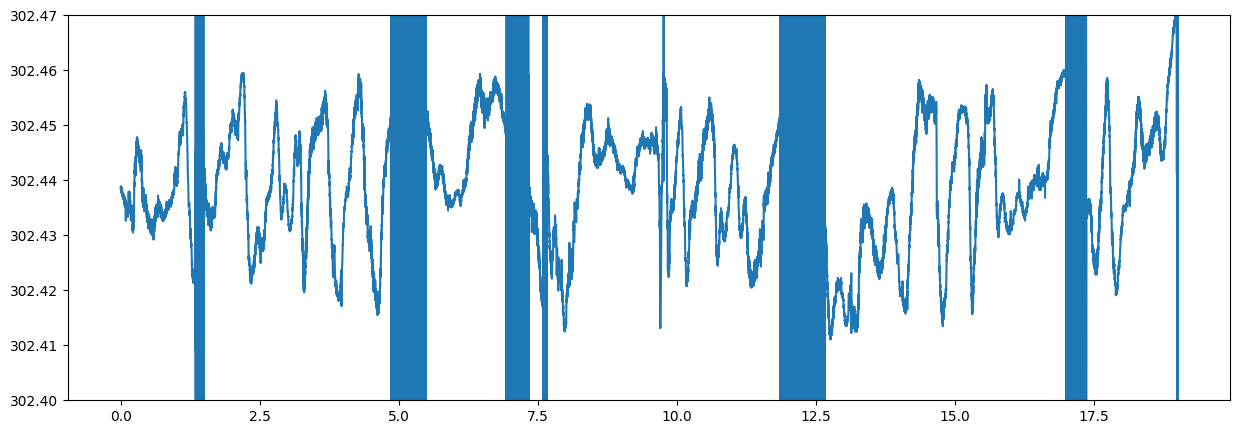

In [10]:
plt.figure(figsize=(15, 5))
plt.plot(bs.time_sec/86400, bs.fj_fs)
plt.ylim(flim1, flim2)

### Load Maintenance Log

In [11]:
from functions.load_lxx import __load_lxx

lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

In [12]:
from functions.get_lxx_intervals import __get_lxx_intervals

lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

### Load MLTI Log

In [13]:
from functions.load_mlti import __load_mlti

mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

In [14]:
from functions.get_mlti_intervals import __get_mlti_intervals

mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

In [15]:
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN


for key in ["fj_fs", "fj_bs", "f1_fs", "f2_fs", "f1_ac", "f2_ac", "f1_dc", "f2_dc", "f1_ph", "f2_ph"]:
    bs = __mlti_intervals_to_NaN(bs, key, "time1", mltiU_t1, mltiU_t2, t_offset_sec=300)


### Apply Selections

In [16]:
# tt1, tt2 = "2023-11-20 14:00", "2024-01-11"
# cond1 = bs.time1 > tt1
# cond2 = bs.time1 < tt2
# cond3 = bs.fj_fs_nan < 302.4
# cond4 = bs.fj_fs_nan > 302.6

# bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_fs_nan)
# bs['fj_fs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_fs_nan)

# bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond3, np.nan, bs.fj_bs_nan)
# bs['fj_bs_nan'] = np.where(cond1 & cond2 & cond4, np.nan, bs.fj_bs_nan)


In [17]:
from functions.interpolate_nan import __interpolate_nan

bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))
bs['fj_bs_inter'] = __interpolate_nan(np.array(bs.fj_bs_nan))

In [18]:
from functions.smoothing import __smooth

n_minutes = 180

bs['fj_fs_smooth'] = __smooth(bs.fj_fs_inter, n_minutes)
bs['fj_bs_smooth'] = __smooth(bs.fj_bs_inter, n_minutes)

/tmp/ipykernel_416742/4063111886.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tcklbls)


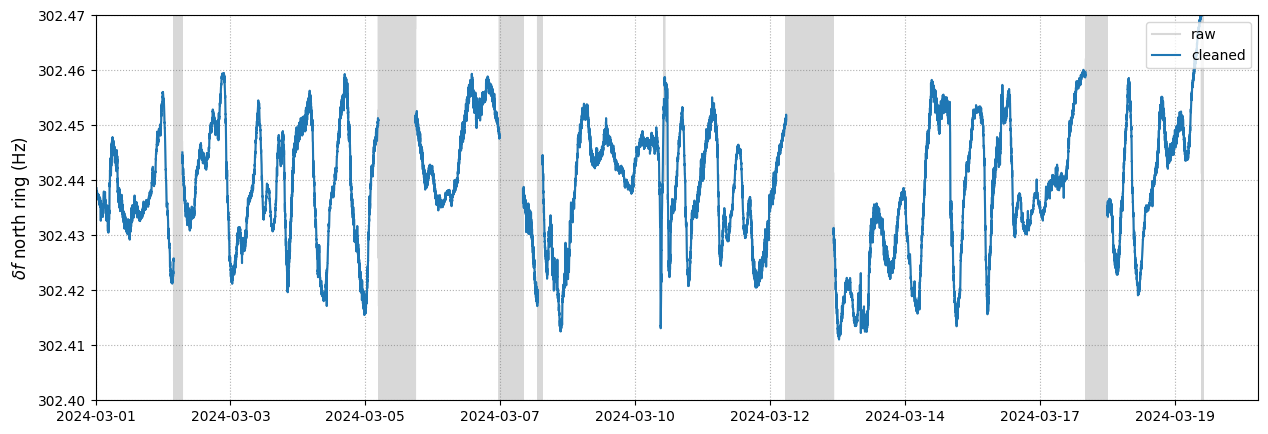

In [19]:
def __makeplot():

    Nrow, Ncol = 1, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1

    ref_date = str(bs.time1.iloc[0])[:10]

    ax.plot(bs.time_sec*time_scaling, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax.plot(bs.time_sec*time_scaling, bs.fj_fs_nan, color="tab:blue", label="cleaned")
    # ax.plot(bs.time_sec*time_scaling, bs.fj_fs_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax.set_ylim(flim1, flim2)
    ax.ticklabel_format(useOffset=False)
    ax.set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ax.grid(ls=":", zorder=0)
    ax.legend(loc=1)
    ax.set_xlim(left=0)


    ## add dates to x-axis
    tcks = ax.get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax.set_xticklabels(tcklbls)

    ## add maintenance times
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax.fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_cleaned.png", format="png", dpi=150, bbox_inches='tight')


## Overview Plot

/tmp/ipykernel_416742/2562948847.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[Nrow-1].set_xticklabels(tcklbls)


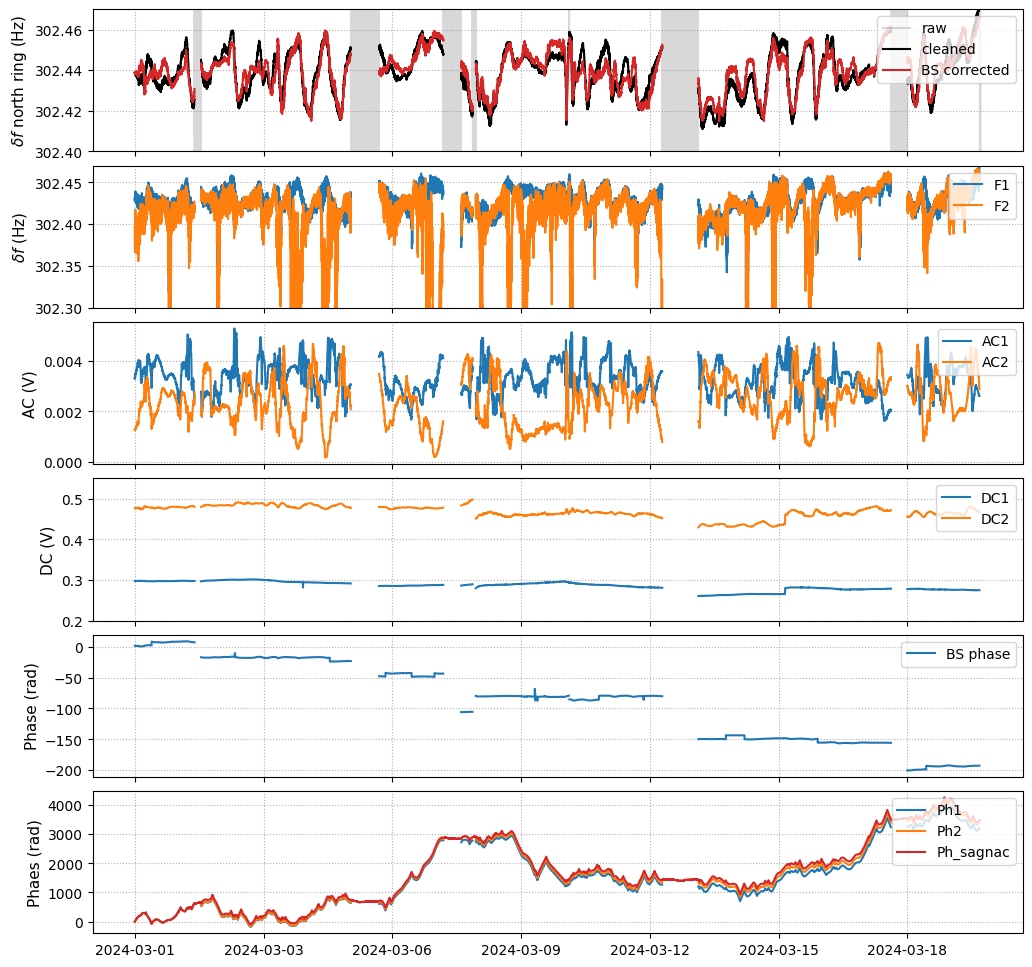

In [20]:
def __makeplot_sagnac_overview():

    Nrow, Ncol = 6, 1

    font = 11

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 12), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1

    ref_date = str(bs.time1.iloc[0])[:10]

    ## -----------------------------------------------------------------------------

    ax[0].plot(bs.time_sec, bs.fj_fs, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(bs.time_sec, bs.fj_fs_nan, color="black", label="cleaned")
    ax[0].plot(bs.time_sec, bs.fj_bs_nan, color="tab:red", label="BS corrected")

    ax[0].set_ylim(flim1, flim2)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta f$ north ring (Hz)", fontsize=font)

    ## -----------------------------------------------------------------------------

    ax[1].plot(bs.time_sec, bs.f1_fs_nan, color="tab:blue", label="F1")
    ax[1].plot(bs.time_sec, bs.f2_fs_nan, color="tab:orange", label="F2")

    ax[1].set_ylim(flim1-0.1, flim2)
    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylabel("$\delta f$ (Hz)", fontsize=font)



    ## -----------------------------------------------------------------------------

    ax[2].plot(bs.time_sec, bs.f1_ac_nan, color="tab:blue", label="AC1")
    ax[2].plot(bs.time_sec, bs.f2_ac_nan, color="tab:orange", label="AC2")

    ax[2].set_ylabel("AC (V)", fontsize=font)


    ## -----------------------------------------------------------------------------

    ax[3].plot(bs.time_sec, bs.f1_dc_nan, color="tab:blue", label="DC1")
    ax[3].plot(bs.time_sec, bs.f2_dc_nan, color="tab:orange", label="DC2")

    ax[3].set_ylabel("DC (V)", fontsize=font)
    ax[3].set_ylim(0.2, 0.55)

    ## -----------------------------------------------------------------------------

    ax[4].plot(bs.time_sec, bs.f1_ph_nan-bs.f2_ph_nan, color="tab:blue", label="BS phase")
    # ax[4].set_ylim(-12, 12)

    ax[4].set_ylabel("Phase (rad)", fontsize=font)

    ## -----------------------------------------------------------------------------

    ax[5].plot(bs.time_sec, bs.f1_ph_nan, color="tab:blue", label="Ph1")
    ax[5].plot(bs.time_sec, bs.f2_ph_nan, color="tab:orange", label="Ph2")
    ax[5].plot(bs.time_sec, bs.fj_ph, color="tab:red", label="Ph_sagnac")

    ax[5].set_ylabel("Phaes (rad)", fontsize=font)

    for _k in range(Nrow):
        ax[_k].grid(ls=":", zorder=0)
        ax[_k].legend(loc=1)

    ## add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    ## add maintenance times
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        for _n in range(Nrow):
            ax[_n].fill_betweenx([ax[_n].get_ylim()[0], ax[_n].get_ylim()[1]], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    plt.show();
    return fig

fig = __makeplot_sagnac_overview();

# fig.savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_cleaned.png", format="png", dpi=150, bbox_inches='tight')


### Compute PSD

/tmp/ipykernel_416742/4031747786.py:53: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[1].set_xlim(0, 1e-3)
/tmp/ipykernel_416742/4031747786.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(tcklbls)


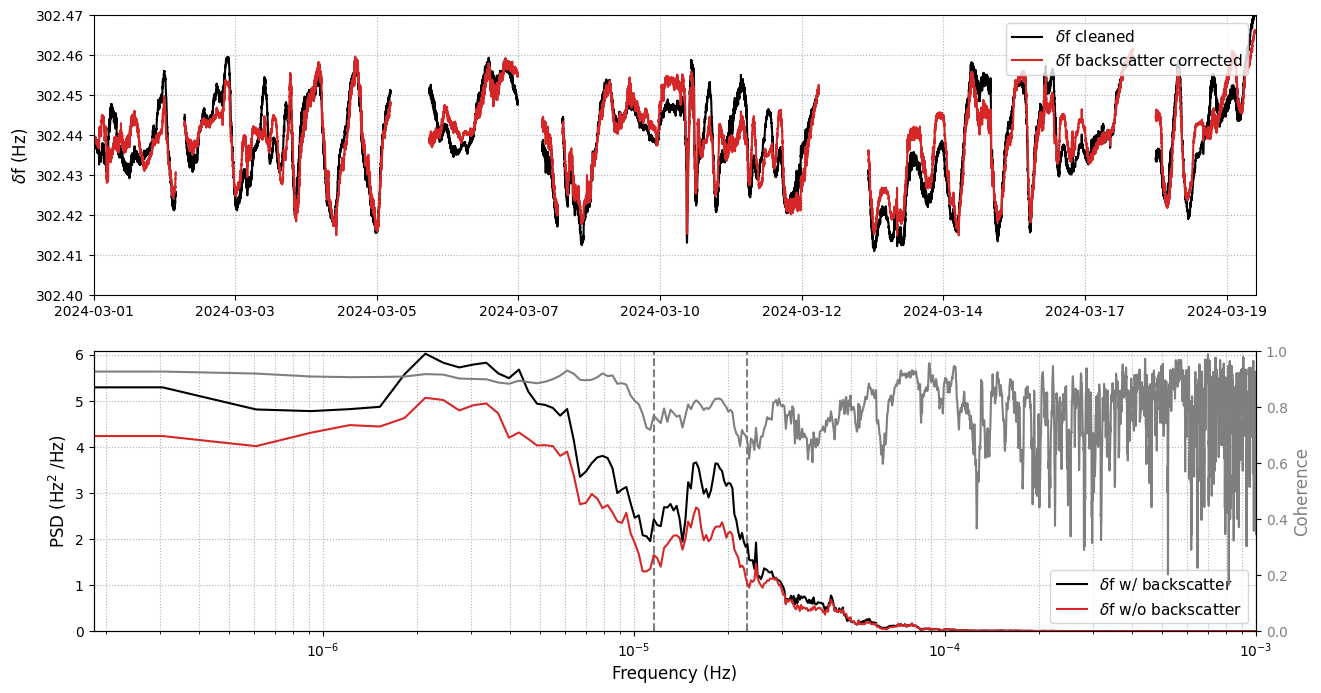

In [21]:
def __makeplot(key1, key2, fft=False):

    dat1 = np.array((bs[key1] - bs[key1].mean()).replace(np.nan, 0))
    dat2 = np.array((bs[key2] - bs[key2].mean()).replace(np.nan, 0))


    out = __multitaper_coherence(dat1, dat2, 60, n_taper=10, time_bandwidth=3.5, method=0)


    f1, psd1, pha1 = __get_fft(dat1, 60)
    f2, psd2, pha2 = __get_fft(dat2, 60)


    Nrow, Ncol = 2, 1

    font = 12

    time_scaling = 1

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))


    ax[0].plot(bs.time_sec*time_scaling, bs[key1], color="black", label=f"$\delta$f cleaned")
    ax[0].plot(bs.time_sec*time_scaling, bs[key2], color="tab:red", label=f"$\delta$f backscatter corrected")

    ax[0].ticklabel_format(useOffset=False)

    if fft:
        ax[1].semilogx(f1, psd1, color="black", label=f"$\delta$f cleaned")
        ax[1].semilogx(f2, psd2, color="tab:red", label=f"$\delta$f backscatter corrected")
        ax[1].set_ylim(0, max(psd1)+0.2*max(psd1))
        ax[1].set_ylabel("Spectrum (Hz $\sqrt{Hz}$)", fontsize=font)
    else:
        ax[1].semilogx(out['ff1'], out['psd1'], color="black", label=f"$\delta$f w/ backscatter")
        ax[1].semilogx(out['ff2'], out['psd2'], color="tab:red", label=f"$\delta$f w/o backscatter")
        ax[1].set_ylim(0, max(out['psd2'])*1.2)
        ax[1].set_ylabel("PSD (Hz$^2$ /Hz)", fontsize=font)

    ax11 = ax[1].twinx()
    ax11.semilogx(out['fcoh'], out['coh'], color="tab:grey", label=f"coherence")
    ax11.set_ylim(0, 1.)
    ax11.set_ylabel(f"Coherence", fontsize=font, color="tab:grey")
    [t.set_color('tab:grey') for t in ax11.yaxis.get_ticklabels()]

    for _n in range(Nrow):
        ax[_n].grid(which="both", ls=":", zorder=0)
        ax[_n].legend(loc=1, fontsize=font-1)

    # ax[0].set_ylim(302.395, 302.465)
    ax[0].set_ylim(flim1, flim2)
    ax[0].set_xlim(0, max(bs.time_sec)*time_scaling)

    ax[1].set_xlim(0, 1e-3)

    ax[1].legend(loc=4, fontsize=font-1)

    ax[0].set_ylabel(f"$\delta$f (Hz)", fontsize=font)
    # ax[0].set_xlabel(f"Time from {config['tbeg'].date} {config['tbeg'].time} UTC (hours)", fontsize=font)

    ax[1].set_xlabel("Frequency (Hz)", fontsize=font)

    ax[1].axvline(1/(12*3600), ls="--", color="grey", zorder=0)
    ax[1].axvline(1/(24*3600), ls="--", color="grey", zorder=0)

    ## add dates to x-axis
    ref_date = str(bs.time1.iloc[0])[:10]
    tcks = ax[0].get_xticks()
    tcklbls = [UTCDateTime(UTCDateTime(ref_date)+t).date for t in tcks]
    ax[0].set_xticklabels(tcklbls)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot("fj_fs_nan", "fj_bs_nan", fft=False);
# fig = __makeplot("fj_fs_inter", "w_s_inter");

fig.savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_PSD_inter.png", format="png", dpi=150, bbox_inches='tight')


### Compute CWT

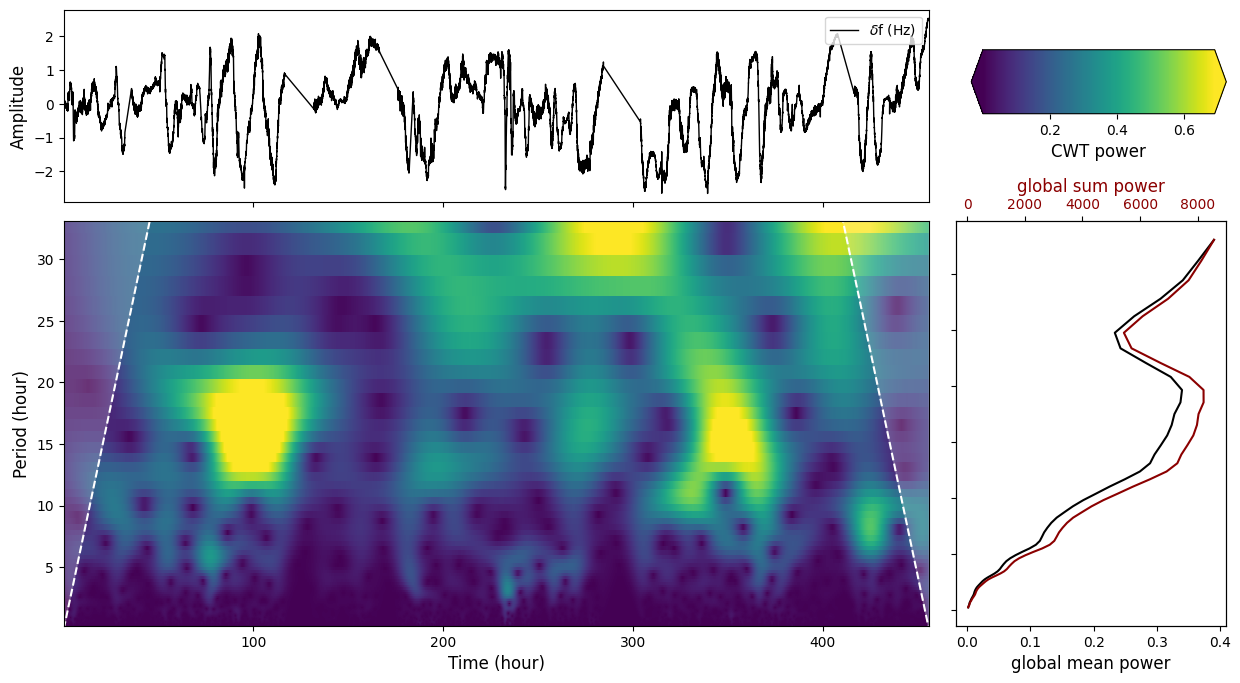

In [22]:
ttt = bs.time_sec
arr = bs.fj_bs_inter
dt  = 60 # seconds

out = __compute_cwt(ttt, arr, dt,
                    tscale="hour",
                    datalabel="$\delta$f (Hz)",
                    scale_value=15,
                    log=False, period=True, ymax=None, plot=True,
                   )

out['fig'].savefig(config['path_to_figs']+f"SF_BS_RU_multiday_Case{case}_CWT.png", format="png", dpi=200, bbox_inches='tight')
